# Custom CNN for HER2 IHC Image Classification
## Info
### Version: V2.0.0
#### Changes:
Explanable AI with Lime has been Initiated!

In [1]:
# Version information
version_info = """
Project Version: 1.0.0
Release Date: 2025-01-15
Author: Saky
"""

In [2]:
# Write to version.txt
with open("/kaggle/working/version.txt", "w") as f:
    f.write(version_info)

# Check the content by reading it back
with open("/kaggle/working/version.txt", "r") as f:
    print(f.read())


Project Version: 1.0.0
Release Date: 2025-01-15
Author: Saky



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import shap
from keras.preprocessing import image
import tensorflow.keras.backend as K

2025-04-28 02:25:22.280104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745807122.484781      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745807122.542541      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is enabled!")
else:
    print("GPU is not enabled.")

GPU is enabled!


In [5]:
# Path to your dataset
train_dir = "/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch"
test_dir = "/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/test_data_patch"

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical', #Use categorical for multi-class classification
    shuffle=True,
    # Add these arguments here:
    # workers=8, # Example value, adjust based on your system's CPU cores
    # use_multiprocessing=True, # Set to True to use multiprocessing
    # max_queue_size=10 # Example value, adjust as needed
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical', #Use categorical for multi-class classification
    shuffle=False,
    # # Add these arguments here for the test generator as well:
    # workers=8, # Example value
    # use_multiprocessing=True, # Set to True
    # max_queue_size=10 # Example value
)



Found 8797 images belonging to 4 classes.
Found 2200 images belonging to 4 classes.


In [6]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential()
    
    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Flatten and Dense Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes for multi-class classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build and summarize the model
model = build_custom_cnn()
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
I0000 00:00:1745807142.679473      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,348 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=200,  # Adjust epochs based on dataset size and performance
    # validation_data=test_generator,
    # validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/200


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
I0000 00:00:1745807153.252245     107 service.cc:148] XLA service 0x7bc6e000c5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745807153.253199     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745807153.587481     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/274 ━━━━━━━━━━━━━━━━━━━━ 58:13 13s/step - accuracy: 0.1875 - loss: 1.4114

I0000 00:00:1745807158.116775     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 170s 576ms/step - accuracy: 0.6352 - loss: 0.8096
Epoch 2/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.8750 - loss: 0.3833
Epoch 3/200


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


274/274 ━━━━━━━━━━━━━━━━━━━━ 127s 453ms/step - accuracy: 0.8133 - loss: 0.4490
Epoch 4/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.8125 - loss: 0.3551
Epoch 5/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 128s 453ms/step - accuracy: 0.8338 - loss: 0.4048
Epoch 6/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.8438 - loss: 0.3493
Epoch 7/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 129s 458ms/step - accuracy: 0.8395 - loss: 0.3877
Epoch 8/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.8438 - loss: 0.3250
Epoch 9/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 128s 456ms/step - accuracy: 0.8596 - loss: 0.3466
Epoch 10/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 0.9062 - loss: 0.1907
Epoch 11/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 129s 458ms/step - accuracy: 0.8672 - loss: 0.3319
Epoch 12/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.9062 - loss: 0.3467
Epoch 13/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 128s 457ms/step - accuracy: 0.8767 - loss: 0.3167
Epoch 14/200
274/274 ━

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 384ms/step - accuracy: 0.9248 - loss: 0.2140
Test accuracy: 92.56%


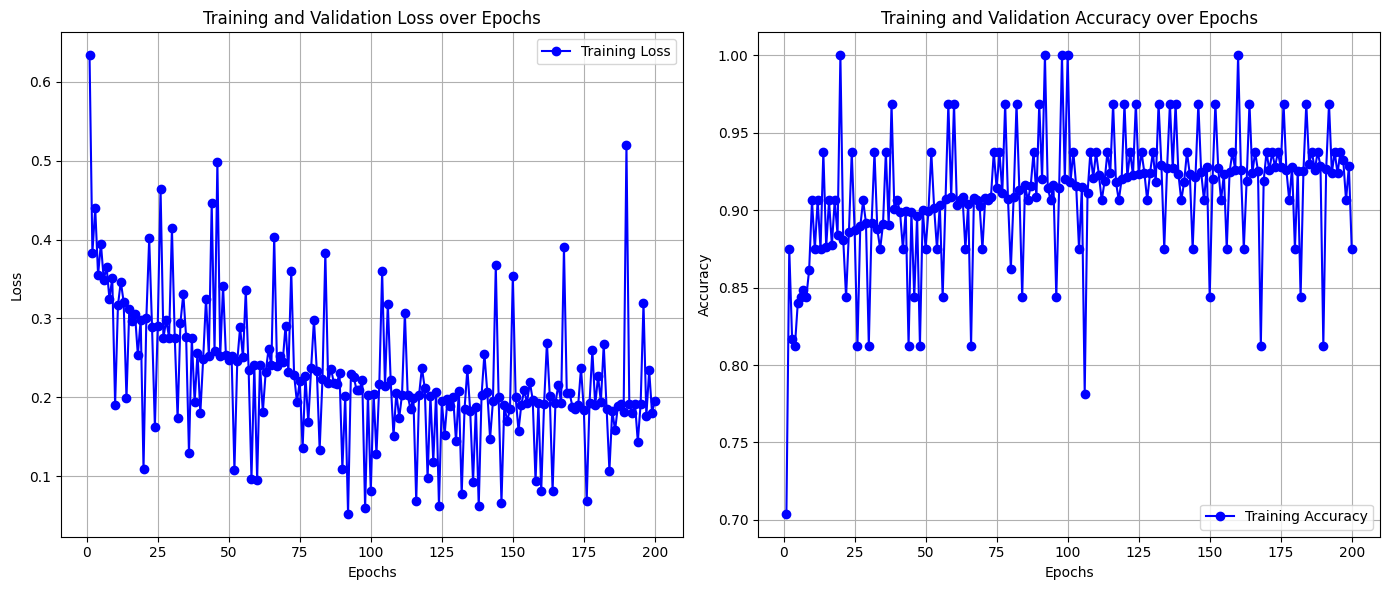

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' is the object returned by model.fit()
# If you named it differently, replace 'history' with your variable name

# Get the training loss and accuracy from the history object
# These are stored in the 'history' attribute of the history object
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# It's highly recommended to also visualize validation metrics if you are using validation data
# Check if validation data was used in model.fit() (by uncommenting those lines)
val_loss = None
val_accuracy = None
if 'val_loss' in history.history:
    val_loss = history.history['val_loss']
if 'val_accuracy' in history.history:
    val_accuracy = history.history['val_accuracy']


# Get the number of epochs the training ran for
epochs = range(1, len(train_loss) + 1)

# Create a figure to hold our plots
plt.figure(figsize=(14, 6)) # Adjust figure size as needed for better readability

# Plot Training Loss (and Validation Loss if available)
plt.subplot(1, 2, 1) # This creates the first plot in a 1 row, 2 column grid
plt.plot(epochs, train_loss, 'bo-', label='Training Loss') # 'bo-' creates blue circles with lines
if val_loss is not None:
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss') # 'r-' creates a red line
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() # Show the legend to identify the lines
plt.grid(True) # Add a grid for easier reading

# Plot Training Accuracy (and Validation Accuracy if available)
plt.subplot(1, 2, 2) # This creates the second plot in the 1 row, 2 column grid
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy') # 'bo-' creates blue circles with lines
if val_accuracy is not None:
     plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy') # 'r-' creates a red line
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() # Show the legend
plt.grid(True) # Add a grid

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()

# Display the plots
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


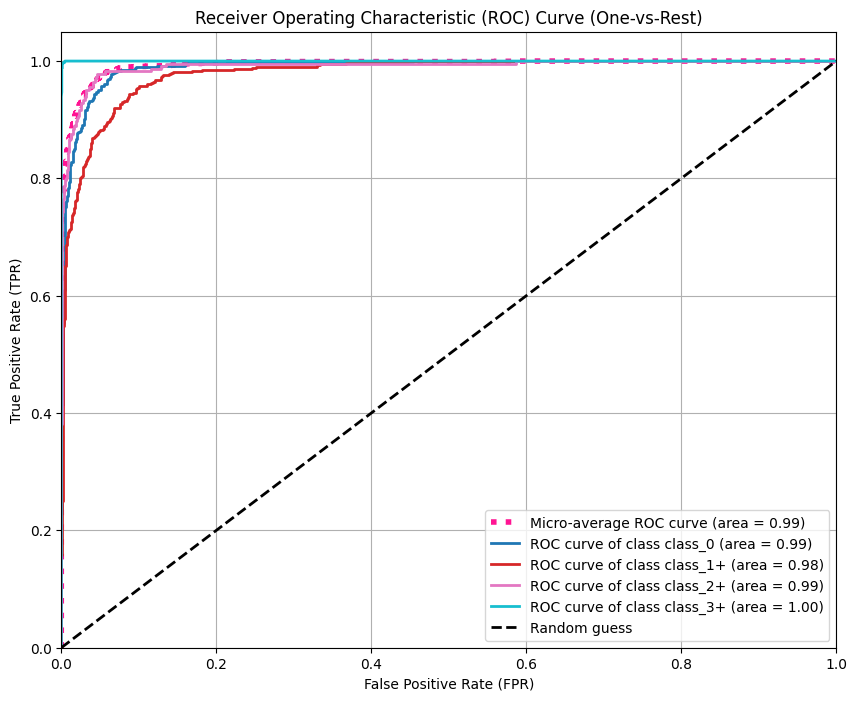

AUC for each class (One-vs-Rest):
  Class class_0: 0.99
  Class class_1+: 0.98
  Class class_2+: 0.99
  Class class_3+: 1.00
Micro-average AUC: 0.99


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize # Needed to convert labels to one-hot encoding

# --- Prerequisites ---
# Ensure you have run model.predict on your test_generator to get the predicted probabilities.
# It's crucial that the order of samples in predictions matches the order of true_classes from the generator.
# A common way to ensure this is to get the predictions first, then access the classes from the generator.

# Assuming you have already run:
# predictions = model.predict(test_generator)
# true_classes = test_generator.classes # Get the true labels

# Get the true labels and predicted probabilities from your test set
# Make sure the test_generator is not shuffled when you get predictions and true_classes
# (shuffle=False is already set for your test_generator in your code, which is good)
predictions = model.predict(test_generator)
true_classes = test_generator.classes

# Get the list of class names from the generator
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names) # Get the number of classes

# --- ROC Curve Calculation (One-vs-Rest) ---

# Binarize the true labels for One-vs-Rest approach
# This converts your integer class labels (0, 1, 2, 3) into a one-hot encoded format
# Example: label 2 becomes [0, 0, 1, 0] for 4 classes
true_classes_binarized = label_binarize(true_classes, classes=np.arange(n_classes))

# Compute ROC curve and ROC area (AUC) for each class individually (One-vs-Rest)
fpr = dict() # Dictionary to store False Positive Rates for each class
tpr = dict() # Dictionary to store True Positive Rates for each class
roc_auc = dict() # Dictionary to store AUC for each class

for i in range(n_classes):
    # roc_curve calculates the FPR and TPR for different probability thresholds
    # It compares the true binary labels for class i against the predicted probabilities for class i
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    # auc calculates the Area Under the ROC Curve using the computed FPR and TPR
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Micro-average ROC curve and ROC area
# This combines the true positives, false positives, etc., across all classes to compute a single ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(true_classes_binarized.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Plotting the ROC Curves ---

plt.figure(figsize=(10, 8)) # Set the figure size for better readability

# Plot the Micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot the ROC curve for each class (One-vs-Rest)
# We use a colormap to get distinct colors for each class
colors = plt.cm.get_cmap('tab10', n_classes) # 'tab10' is a common colormap with 10 distinct colors
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, # lw is linewidth
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot the diagonal line representing a random guess (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random guess') # 'k--' creates a black dashed line

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05]) # Slightly extend y-axis limit for better visualization
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc="lower right") # Position the legend
plt.grid(True) # Add a grid to the plot

# Display the plot
plt.show()

# --- Print AUC values ---
print("AUC for each class (One-vs-Rest):")
for i in range(n_classes):
    print(f"  Class {class_names[i]}: {roc_auc[i]:.2f}")
print(f"Micro-average AUC: {roc_auc['micro']:.2f}")


In [11]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os # Import os module for path operations if needed (though filepaths should be full paths)
# # Import Keras image loading functions for consistency with preprocessing
# from tensorflow.keras.preprocessing import image

# # --- Prerequisites ---
# # Ensure you have run model.predict on your test_generator and have the results.
# # It's crucial that the order of samples in predictions, predicted_classes,
# # true_classes, and test_generator.filepaths is consistent.
# # Since you used shuffle=False for the test_generator, this should be the case.

# # Assuming you have already run:
# # predictions = model.predict(test_generator)
# # predicted_classes = np.argmax(predictions, axis=1) # Get the predicted class index for each sample
# # true_classes = test_generator.classes # Get the true class index for each sample

# # Get the list of file paths for the test set from the generator
# test_image_paths = test_generator.filepaths

# # Get the list of class names from the generator's class_indices
# class_names = list(test_generator.class_indices.keys())

# # --- Identify Misclassified Samples ---

# # Find the indices in the test set where the true class does NOT match the predicted class
# misclassified_indices = np.where(true_classes != predicted_classes)[0]

# print(f"Found {len(misclassified_indices)} misclassified examples out of {len(true_classes)} test samples.")

# # --- Visualize Misclassified Samples ---

# # Define how many misclassified examples you want to visualize
# num_examples_to_show = 10 # You can change this number to visualize more or fewer examples

# # Create a figure to display the images
# # We'll arrange them in a single column. Adjust figure size based on num_examples_to_show
# plt.figure(figsize=(15, num_examples_to_show * 2)) # Adjust the height multiplier as needed

# # Iterate through the first 'num_examples_to_show' indices of misclassified samples
# # Use [:num_examples_to_show] to avoid errors if there are fewer misclassified samples than num_examples_to_show
# for i, misclassified_idx in enumerate(misclassified_indices[:num_examples_to_show]):
#     # Get the original image file path for the misclassified sample
#     image_path = test_image_paths[misclassified_idx]

#     # Get the true and predicted class labels (indices) for this sample
#     true_label = true_classes[misclassified_idx]
#     predicted_label = predicted_classes[misclassified_idx]

#     # Get the true and predicted class names using the indices
#     true_class_name = class_names[true_label]
#     predicted_class_name = class_names[predicted_label]

#     # Load the original image using Keras's image loading function
#     # Use the same target_size as you used for training
#     img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
#     # Convert the image to a numpy array and rescale to 0-1 for displaying
#     img_array = image.img_to_array(img) / 255.0 # Assuming original images are 0-255

#     # Create a subplot for the current misclassified image
#     # We create num_examples_to_show rows, 1 column, and this is the (i+1)-th plot
#     plt.subplot(num_examples_to_show, 1, i + 1)

#     # Display the image
#     plt.imshow(img_array)

#     # Set the title for the subplot to show true and predicted labels
#     plt.title(f"True: {true_class_name}, Predicted: {predicted_class_name}", color='red') # Highlight misclassification in red
#     plt.axis('off') # Hide the axes for cleaner image display

# # Adjust layout to prevent titles/images from overlapping
# plt.tight_layout()

# # Display the plots
# plt.show()

NameError: name 'predicted_classes' is not defined

# Prediction and Generating Reports

In [12]:
# Generate predictions for the validation or test set
predictions = model.predict(test_generator)  # Ensure you use the correct generator
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true labels from the generator
true_classes = test_generator.classes  # Ensure you use the same generator as in the prediction step

# Check the number of samples in true and predicted classes
print(f"Number of true labels: {len(true_classes)}")
print(f"Number of predicted labels: {len(predicted_classes)}")

# Ensure the lengths match
if len(true_classes) != len(predicted_classes):
    raise ValueError("Mismatch in number of true and predicted samples. Check the generator settings.")

# Get the class indices to use target names in the report
target_names = list(test_generator.class_indices.keys())

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=target_names))

69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step
Number of true labels: 2200
Number of predicted labels: 2200
              precision    recall  f1-score   support

     class_0       0.92      0.94      0.93       758
    class_1+       0.90      0.82      0.86       538
    class_2+       0.84      0.90      0.87       226
    class_3+       0.99      1.00      0.99       678

    accuracy                           0.93      2200
   macro avg       0.91      0.92      0.91      2200
weighted avg       0.93      0.93      0.93      2200



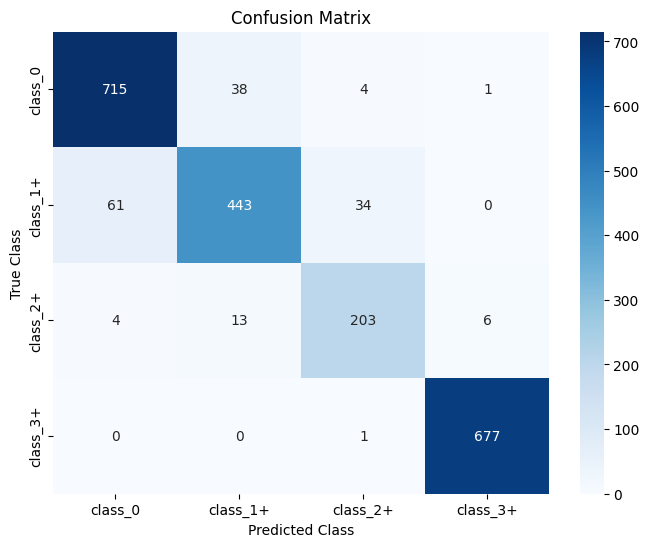

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

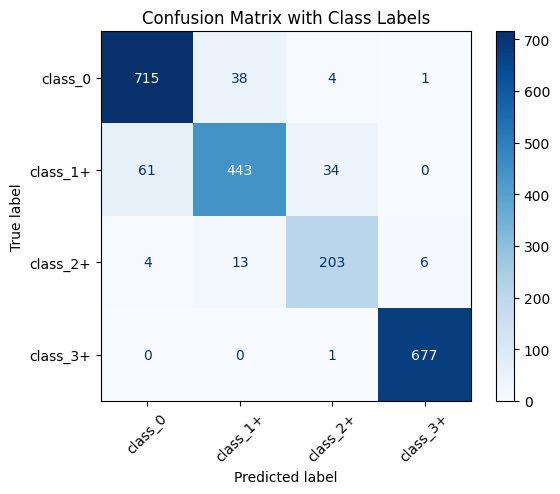

In [14]:
# Optional: Use sklearn's built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix with Class Labels")
plt.show()

In [15]:
# Specify the path where you want to save the model
model_save_path = "/kaggle/working/hundred_epochs_cnn.h5"  # Use .h5 for HDF5 format or .tf for TensorFlow SavedModel format

# Save the trained model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/hundred_epochs_cnn.h5


In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    print(layer.name)

In [ ]:
print(model.input_shape)  # Expected input shape for the model

## Explanable AI with Lime

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from PIL import Image

def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    
    # Resize the image to the target size
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # If the image has only 1 channel (grayscale), convert it to 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.stack([img_array] * 3, axis=-1)  # Convert to RGB by stacking
    elif img_array.shape[-1] == 4:  # RGBA image (has alpha channel)
        img_array = img_array[..., :3]  # Remove the alpha channel
    
    # Ensure the image is in RGB format
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Preprocess the image (for MobileNetV2 model, you can use preprocess_input)
    img_array = preprocess_input(img_array)
    
    return img_array

# Use the preprocess_image function before passing the image to the model
image_path = '/kaggle/input/train-pvt-intnsty/class_2+/her2-2+-score_test_09.png'  # Replace with your actual image path
preprocessed_image = preprocess_image(image_path)

# Now, you can pass the preprocessed image to your model
prediction = model.predict(preprocessed_image)
print(prediction)


In [ ]:
predicted_class = np.argmax(prediction)
print(predicted_class)  # This will give the index of the class with the highest probability

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from PIL import Image

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    
    # Resize the image to the target size
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # If the image has only 1 channel (grayscale), convert it to 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.stack([img_array] * 3, axis=-1)  # Convert to RGB by stacking
    elif img_array.shape[-1] == 4:  # RGBA image (has alpha channel)
        img_array = img_array[..., :3]  # Remove the alpha channel
    
    # Ensure the image is in RGB format
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Preprocess the image (for MobileNetV2 model, you can use preprocess_input)
    img_array = preprocess_input(img_array)
    
    return img_array

# Load the model (replace with the actual path to your model)
model = load_model('/kaggle/working/custom_cnn_model_updated.h5')  # Ensure you load the correct model

# List of class names (update this with your actual class names)
class_names = ['class_0', 'class_1', 'class_2']  # Modify based on your classes

# Path to the image you want to classify
image_path = '/kaggle/input/train-pvt-intnsty/class_2+/her2-2+-score_test_09.png'  # Replace with your actual image path

# Preprocess the image before passing it to the model
preprocessed_image = preprocess_image(image_path)

# Make a prediction using the model
prediction = model.predict(preprocessed_image)

# Print the raw prediction probabilities
print("Prediction probabilities:", prediction)

# Find the index of the class with the highest probability
class_index = np.argmax(prediction, axis=-1)

# Ensure the class index is within bounds of class_names
if class_index[0] < len(class_names):
    predicted_class = class_names[class_index[0]]
    print(f"Predicted class label: {predicted_class}")
else:
    print("Class index is out of range. Check the model's output.")